In [3]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1QfQmubcwB51Xjdxb1c7iRmJVp9DTwZEb

Downloading...
From: https://drive.google.com/uc?id=1QfQmubcwB51Xjdxb1c7iRmJVp9DTwZEb
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 16.3MB/s]


# Pre process

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [48]:
df = pd.read_csv('Mall_Customers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [49]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [50]:
df['Gender'] = df['Gender'].map({'Female':0, 'Male':1})
X = df.iloc[:, 1:].values

# PCA

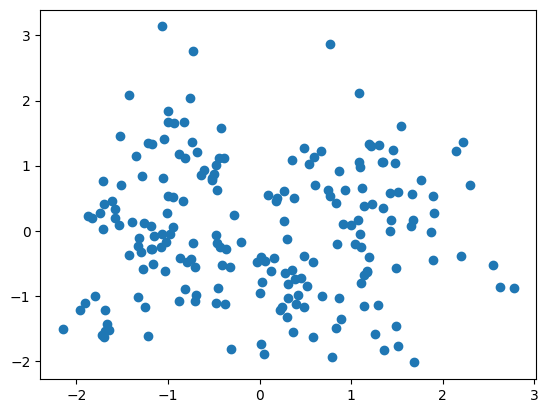

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=93)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

# K-means

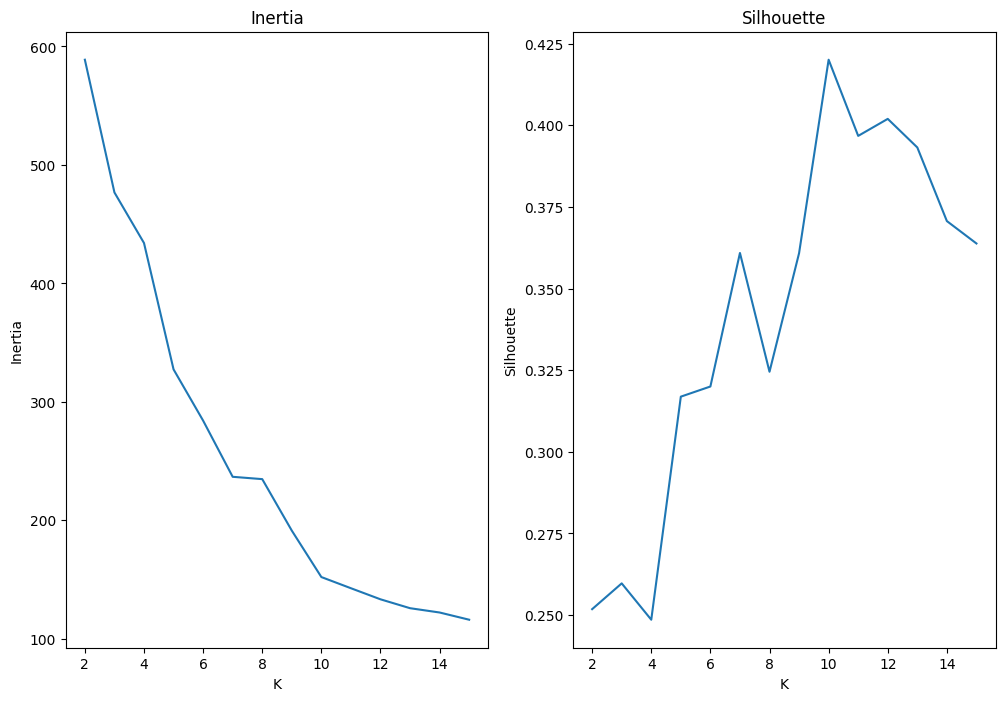

In [42]:
inertia = []
sillhouette = []
K = list(range(2, 16))

for k in K:
    model = KMeans(n_clusters=k, random_state=93, max_iter=1000)
    labels = model.fit_predict(X_scaled)
    inertia.append(model.inertia_)
    sillhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 8))
plt.subplot(1,2, 1)
plt.plot(K, inertia)
plt.title('Inertia')
plt.xlabel('K')
plt.ylabel('Inertia')

plt.subplot(1,2, 2)
plt.plot(K, sillhouette)
plt.title('Silhouette')
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.show()


# Agglomerative Clustering

In [44]:
selected_k = 10

linkage_methods = ['ward', 'average', 'complete', 'single']

print(f"--- Comparing Linkages for chosen K = {selected_k} ---")

best_score = -1

for method in linkage_methods:
    model = AgglomerativeClustering(n_clusters=selected_k, linkage=method)

    labels = model.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, labels)

    print(f"Linkage: {method:10} | Silhouette: {score:.4f}")

    if score > best_score:
        best_score = score
        best_method = method

print("-" * 40)
print(f"Best Linkage is '{best_method}' with Silhouette Score: {best_score:.4f}")


--- Comparing Linkages for chosen K = 10 ---
Linkage: ward       | Silhouette: 0.4176
Linkage: average    | Silhouette: 0.3743
Linkage: complete   | Silhouette: 0.3526
Linkage: single     | Silhouette: -0.0004
----------------------------------------
Best Linkage is 'ward' with Silhouette Score: 0.4176


# DBSCAN

In [45]:
eps_values = [0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_values = [3, 5, 10]

results_list = []

print(f"{'Eps':<5} | {'Min_S':<5} | {'Clusters':<8} | {'Noise %':<8} | {'Silhouette (Non-Noise)':<22}")
print("-" * 65)

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_total = len(labels)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / n_total

        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        n_clusters = len(unique_labels)

        if n_clusters > 1:
            non_noise_mask = labels != -1
            X_core = X_scaled[non_noise_mask]
            labels_core = labels[non_noise_mask]

            if len(set(labels_core)) > 1:
                sil_score = silhouette_score(X_core, labels_core)
            else:
                sil_score = -1.0
        else:
            sil_score = -1.0

        print(f"{eps:<5.1f} | {min_samples:<5} | {n_clusters:<8} | {noise_ratio:<8.2%} | {sil_score:<22.4f}")


        if sil_score > best_score:
            best_score = sil_score
            best_params = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'noise_ratio': noise_ratio}

Eps   | Min_S | Clusters | Noise %  | Silhouette (Non-Noise)
-----------------------------------------------------------------
0.2   | 3     | 7        | 89.50%   | 0.7668                
0.2   | 5     | 0        | 100.00%  | -1.0000               
0.2   | 10    | 0        | 100.00%  | -1.0000               
0.4   | 3     | 18       | 48.50%   | 0.5501                
0.4   | 5     | 4        | 82.50%   | 0.7116                
0.4   | 10    | 0        | 100.00%  | -1.0000               
0.6   | 3     | 13       | 13.00%   | 0.3265                
0.6   | 5     | 9        | 31.00%   | 0.3407                
0.6   | 10    | 3        | 73.50%   | 0.5992                
0.8   | 3     | 4        | 5.50%    | 0.1987                
0.8   | 5     | 5        | 9.50%    | 0.2273                
0.8   | 10    | 4        | 34.00%   | 0.3193                
1.0   | 3     | 3        | 4.00%    | 0.2364                
1.0   | 5     | 2        | 6.50%    | 0.2918                
1.0   | 10    | 2  

# Comparisson

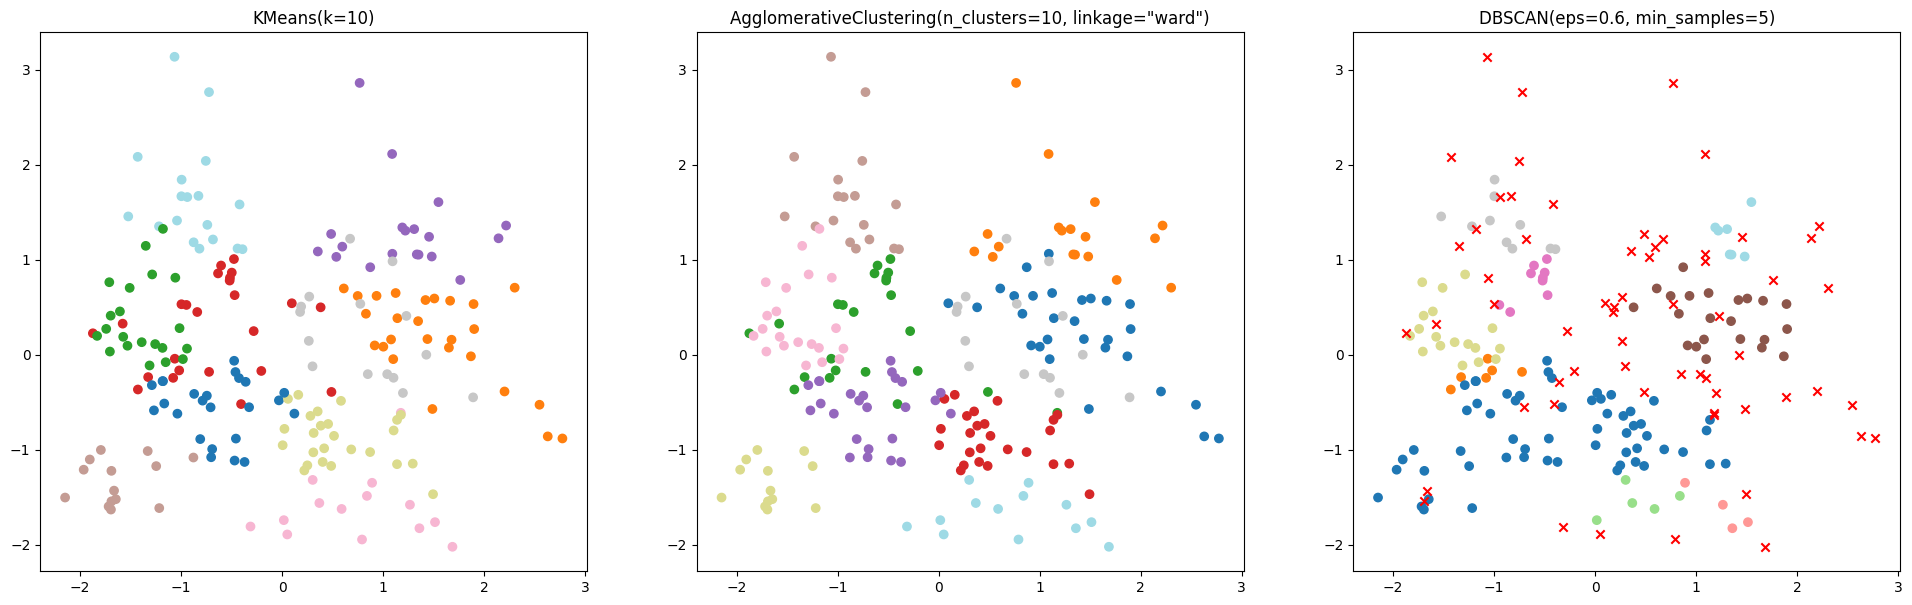

In [47]:
models = [KMeans(n_clusters=10, random_state=93, max_iter=1000),
          AgglomerativeClustering(n_clusters=10, linkage='ward'),
          DBSCAN(eps=0.6, min_samples=5)]
model_names = ['KMeans(k=10)',
               'AgglomerativeClustering(n_clusters=10, linkage="ward")',
               'DBSCAN(eps=0.6, min_samples=5)']
plt.figure(figsize=[24,7])
for i, model in enumerate(models):
    labels = model.fit_predict(X_scaled)
    X_notnoise = X_pca[labels != -1]
    X_noise = X_pca[labels == -1]
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_notnoise[:, 0], X_notnoise[:, 1], c=labels[labels != -1], cmap=plt.get_cmap('tab20'))
    plt.scatter(X_noise[:, 0], X_noise[:, 1], marker='x', color='r')
    plt.title(model_names[i])
plt.show()